<a href="https://colab.research.google.com/github/aohara812/ECGR4127-P2/blob/main/Copy_of_person_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is modified from the visual wake word / person detection MLPerf Tiny Benchmark:
https://github.com/mlcommons/tiny/tree/master/benchmark/training/visual_wake_words

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# %cd /content/drive/MyDrive/Colab Notebooks/IOT/Project2


In [13]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

import os
from absl import app

assert tf.__version__.startswith('2')

In [14]:
IMAGE_SIZE = 96
BATCH_SIZE = 32


batch_size = 50
validation_split = 0.1

epochs = 20,10,20
lrates = .001, .0005, .00025

color_mode = 'grayscale'
if color_mode == 'grayscale':
  n_color_chans = 1
elif color_mode == 'rgb':
  n_color_chans = 3
else:
  raise ValueError("color_mode should be either 'rgb' or 'grayscale'")

# BASE_DIR = os.path.join(os.getcwd(), 'vw_coco2014_96')
BASE_DIR = '/content/drive/MyDrive/Mult_Letters' # Edit this 


Build the model

In [15]:
### vww_model.py
'''
MobilnetV1 from Silican Labs github page:
https://github.com/SiliconLabs/platform_ml_models/blob/master/eembc/Person_detection/mobilenet_v1_eembc.py
'''


#define model
def mobilenet_v1():
    # Mobilenet parameters
    input_shape = [96,96,1] # resized to 96x96 per EEMBC requirement # was [96,96,3]
    num_classes = 3 # person and non-person
    num_filters = 8 # normally 32, but running with alpha=.25 per EEMBC requirement

    inputs = Input(shape=input_shape)
    x = inputs # Keras model uses ZeroPadding2D()

    # 1st layer, pure conv
    # Keras 2.2 model has padding='valid' and disables bias
    x = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) # Keras uses ReLU6 instead of pure ReLU

    # 2nd layer, depthwise separable conv
    # Filter size is always doubled before the pointwise conv
    # Keras uses ZeroPadding2D() and padding='valid'
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 3rd layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 4th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 5th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 6th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 7th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 8th-12th layers, identical depthwise separable convs
    # 8th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 9th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 10th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 11th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 12th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 13th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 14th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Average pooling, max polling may be used also
    # Keras employs GlobalAveragePooling2D 
    x = AveragePooling2D(pool_size=x.shape[1:3])(x)
    #x = MaxPooling2D(pool_size=x.shape[1:3])(x)

    # Keras inserts Dropout() and a pointwise Conv2D() here
    # We are staying with the paper base structure

    # Flatten, FC layer and classify
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [17]:
### train_vww.py
"""Training for the visual wakewords person detection model.

The visual wakewords person detection model is a core model for the TinyMLPerf
benchmark suite. This script provides source for how the reference model was
created and trained, and can be used as a starting point for open submissions
using re-training.
"""

model = mobilenet_v1()

 # model.summary()

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=.1,
    horizontal_flip=True,
    validation_split=validation_split,
    rescale=1. / 255)





train_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    color_mode='grayscale') # was 'rgb'



    
val_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    color_mode='grayscale') # was 'rgb'
print(train_generator.class_indices)


def train_epochs(model, train_generator, val_generator, epoch_count,
                 learning_rate, steps_per_epoch=None):
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate),
      loss='categorical_crossentropy',
      metrics=['accuracy'])
  if steps_per_epoch is None:
    steps_per_epoch = len(train_generator)
  history_fine = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=epoch_count,
      validation_data=val_generator,
      validation_steps=len(val_generator),
      batch_size=BATCH_SIZE)
  return model

model = train_epochs(model, train_generator, val_generator, epochs[0], lrates[0])# steps_per_epoch=10)
model = train_epochs(model, train_generator, val_generator, epochs[1], lrates[1])
model = train_epochs(model, train_generator, val_generator, epochs[2], lrates[2])

model.save('vww_96_tmp_res.h5')


Found 13500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
{'F': 0, 'K': 1, 'OtherLetters': 2}
Epoch 1/20
422/422 [==============================] - 8140s 19s/step - loss: 1.1360 - accuracy: 0.6393 - val_loss: 1.5929 - val_accuracy: 0.6000
Epoch 2/20
422/422 [==============================] - 153s 363ms/step - loss: 0.8802 - accuracy: 0.7519 - val_loss: 1.0286 - val_accuracy: 0.7107
Epoch 3/20
422/422 [==============================] - 153s 362ms/step - loss: 0.6410 - accuracy: 0.8541 - val_loss: 0.7022 - val_accuracy: 0.8373
Epoch 4/20
422/422 [==============================] - 153s 362ms/step - loss: 0.4974 - accuracy: 0.9087 - val_loss: 0.6185 - val_accuracy: 0.8633
Epoch 5/20
422/422 [==============================] - 153s 363ms/step - loss: 0.4152 - accuracy: 0.9373 - val_loss: 0.4617 - val_accuracy: 0.9093
Epoch 6/20
422/422 [==============================] - 154s 365ms/step - loss: 0.3637 - accuracy: 0.9507 - val_loss: 0.4767 - val_accuracy: 0.9293
Epoc

In [18]:
val_loss, val_acc = model.evaluate(val_generator, verbose=2)

47/47 - 9s - loss: 0.4167 - accuracy: 0.9267 - 9s/epoch - 193ms/step


In [19]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 8)         0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 48, 48, 8)        80        
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 8)        32    

In [20]:
### From convert_vww.py

# model = tf.keras.models.load_model(argv[1])
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# with tf.io.gfile.GFile('vww_96_float.tflite', 'wb') as float_file:
#   float_file.write(tflite_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
  dataset_dir = os.path.join(BASE_DIR, "K")
  for idx, image_file in enumerate(os.listdir(dataset_dir)):
    # 10 representative images should be enough for calibration.
    if idx > 10:
        return
    full_path = os.path.join(dataset_dir, image_file)
    if os.path.isfile(full_path):
      img = tf.keras.preprocessing.image.load_img(
          full_path, color_mode=color_mode).resize((96, 96))
      arr = tf.keras.preprocessing.image.img_to_array(img)
      # Scale input to [0, 1.0] like in training.
      yield [arr.reshape(1, 96, 96, n_color_chans) / 255.] 

# Convert model to full-int8 and save as quantized tflite flatbuffer.
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
quantized_tflite_model = converter.convert()
with tf.io.gfile.GFile('vww_96_int8.tflite', 'wb') as quantized_file:
    quantized_file.write(quantized_tflite_model)




INFO:tensorflow:Assets written to: /tmp/tmpp63rc6k_/assets


INFO:tensorflow:Assets written to: /tmp/tmpvx_4vdtr/assets


INFO:tensorflow:Assets written to: /tmp/tmpvx_4vdtr/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [21]:
# rebuild the val-set generator with batch-size = 1
val_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1,
    subset='validation',
    color_mode='grayscale')

Found 1500 images belonging to 3 classes.


In [7]:
# number of MACs in each layer is (# outputs in layer) * (number of inputs that contribute to one output)
macs = np.array([(14*38*20)*(3*3), (7*19*20)*(3*3), (7*19*32)*20, 128*128, 128*128, 4*128])
print(macs)
print(np.sum(macs))

[95760 23940 85120 16384 16384   512]
238100


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
history_fine = model.fit

AttributeError: ignored

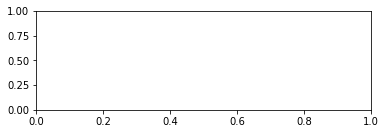

In [44]:
#Will fix later
metrics = history_fine
plt.subplot(2,1,1)
plt.semilogy(history_fine.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(history_fine.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
b = val_generator.next()

In [ ]:
b[1].shape

(1, 3)

In [ ]:
model_out = model.predict(train_generator)
y_pred = np.argmax(model_out, axis=1)
y_true = train_generator.labels

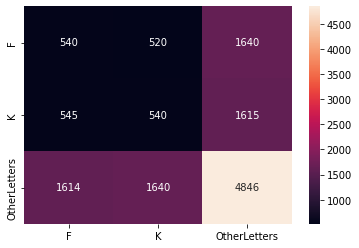

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_mtx, xticklabels=['F', 'K', 'OtherLetters'], yticklabels=['F','K', 'OtherLetters'], annot=True, fmt='g')

[[0. 1. 0.]]


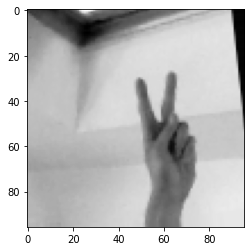

In [ ]:
plt.imshow(-b[0][0,:,:,0], cmap='Greys')
print(b[1])

In [23]:
def evaluate_model(interpreter, datagen):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  labels = labels.squeeze()
  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(inputs):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == labels).mean()
  return accuracy, prediction_digits